In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

In [2]:
%load_ext autoreload
%autoreload 2

# Steps to convert 1st set of ABF files
- read in metadata
- identify files to be converted (from mouse2018, using protocols testing intrinsic properties, ABFv2)
- merge in extracted metadata
- convert using modified ABF1Converter
- validate NWB outputs using dandi-cli
- explore errors


In [3]:
mouse_meta = pd.read_csv('./data/raw/Metadata/Mouse18_Metadatav2.csv')
mouse_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
mouse_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3


In [5]:
mouse_meta['Stim Type'].value_counts()

Gain 40           62
Gain 20           14
Firing pattern    11
Firing             2
Name: Stim Type, dtype: int64

In [6]:
intrinsic_meta = pd.concat([mouse_meta[mouse_meta['Stim Type'] == 'Firing'], mouse_meta[mouse_meta['Stim Type'] == 'Firing pattern']])

## Identify files to be converted
- ABF files from mouse2018
- need metadata to determine which files are testing firing pattern
- extract ABF version info, time of creation and comments from the ABF file

In [7]:
mouse2018_abf_dir = Path("./data/raw/recordings/Mouse data/Mouse data_2018")
mouse2018_file_info = utils.summary_df(mouse2018_abf_dir)

In [8]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

def check_protocolpath_for_experimenter(abf_path):
    abf = pyabf.ABF(abf_path)
    if 'Homeira' in abf.protocolPath:
        return 'Homeira'
    elif 'Lihua' in abf.protocolPath:
        return 'Lihua'
    else:
        #print(abf.protocolPath)
        return None

mouse2018_file_info['timestamp'] = mouse2018_file_info.path.apply(parse_timestamp)
mouse2018_file_info['abf_version'] = mouse2018_file_info.path.apply(extract_abf_version)
mouse2018_file_info['abf_comments'] = mouse2018_file_info.path.apply(extract_abf_comments)
mouse2018_file_info['experimenter'] = mouse2018_file_info.path.apply(check_protocolpath_for_experimenter)


# add this column to merge with provided metadata
mouse2018_file_info['file_id'] = mouse2018_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 2.28 s, sys: 881 ms, total: 3.16 s
Wall time: 3.34 s


In [9]:
mouse2018_file_info.shape

(124, 7)

In [10]:
merged_meta = intrinsic_meta.merge(mouse2018_file_info, left_on='Cell Name', right_on='file_id').drop('Cell Name', axis=1)

## Extract additional required stimulus metadata

In [11]:
merged_meta.loc[0, 'path']

'data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf'

In [12]:
merged_meta.path.apply(lambda x: pyabf.ABF(x).channelList)

0     [0, 1]
1     [0, 1]
2     [0, 1]
3     [0, 1]
4     [0, 1]
5     [0, 1]
6     [0, 1]
7     [0, 1]
8     [0, 1]
9     [0, 1]
10    [0, 1]
11    [0, 1]
12    [0, 1]
Name: path, dtype: object

In [13]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(row.path)
    print(abf_tag)
    
    if len(abf.channelList) == 3:
        #print(abf_file)
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepY'
        
        cell_meta_df = None
        try:
            stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        except AttributeError as e:
            print(e)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}
    #ret_dict = dict(ret_dict.items() + stim_info_dict.items())
    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf
c5, RMP -67.5 mv
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf', 'valid_stim': True, 'stim_amp_vec': array([ 4., -1., -2., ..., -1., -3.,  3.]), 'stim_duration': 0.0567, 'stim_start_time': 0.0051, 'stim_end_time': 1.0267, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2018/Jan 30_2018/C5_L5/Firing/18130014.abf
C5,  L5, RMP: -75.2 mv
num_sweeps: 11
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2018/Jan 30_2018/C5_L5/Firing/18130014.abf', 'valid_stim': True, 'stim_amp_vec': array([-123.,  -74.,  -25., ...,  276.,  326.,  375.]), 'stim_duration': 0.3383, 'stim_start_time': 0.0373, 'stim_end_time': 1

In [14]:
extracted_meta = pd.DataFrame(results_list)

In [15]:
all_meta = merged_meta.merge(extracted_meta.drop('abf_version', axis=1), left_on='file_id', right_on='cell_id').drop('cell_id', axis=1)

In [16]:
all_meta.stimulus_type.value_counts()

longsquare    5
ramp          4
Name: stimulus_type, dtype: int64

In [21]:
# after visual QC, determined stim gains for this dataset need to be set to 400
all_meta.stim_gain = 400

In [22]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'm2018_meta.csv')

In [24]:
all_meta.iloc[0]

Data Type                                                         Mouse
Exp. Date                                                   Jan 16_2018
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                       NaN
Gain                                                                1.0
Offset                                                             17.5
Response Channel                                           Iclamp (mV) 
Command Channel                                          Current_in(pA)
RMP                                                               -67.5
file_name                                                  18116450.abf
path                  data/raw/recordings/Mouse data/Mouse data_

In [25]:
output_dir = Path("data/processed/recordings/mouse2018")
output_dir.mkdir(exist_ok=True)

In [32]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [33]:
all_meta[all_meta.stimulus_type == 'longsquare']

,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,...,stim_chan,stim_gain,stim_path,valid_stim,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
1,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),...,1,400,data/raw/recordings/Mouse data/Mouse data_2018...,True,"[-123.0, -74.0, -25.0, 26.0, 76.0, 126.0, 176....",0.3383,0.0373,1.03580,11,10000
3,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),...,1,400,data/raw/recordings/Mouse data/Mouse data_2018...,True,"[-553.0, -453.0, -350.0, -251.0, -154.0, -51.0...",0.2057,0.0372,1.03680,14,10000
5,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,longsquare,1.0,27.3,Iclamp (mV),...,1,400,data/raw/recordings/Mouse data/Mouse data_2018...,True,"[-550.0, -451.0, -352.0, -248.0, -149.0, -49.0...",0.3353,0.0376,1.03690,13,10000
7,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,longsquare,1.0,23.2,Iclamp (mV),...,1,400,data/raw/recordings/Mouse data/Mouse data_2018...,True,"[-549.0, -449.0, -352.0, -250.0, -148.0, -49.0...",0.2808,0.0373,1.03540,12,10000
9,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,longsquare,20.0,15.4,Iclamp (mV),...,1,400,data/raw/recordings/Mouse data/Mouse data_2018...,True,"[-1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0...",1.0000,0.0428,1.04275,16,20000


In [34]:
%%time
errors = []

for i, file_info in all_meta[all_meta.stimulus_type == 'longsquare'].iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.file_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_tag}',
                'species': 'Homo sapiens',
                'subject_id': f'Donor_'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                                    outputFilePath = str(output_path), 
                                                    acquisitionChannelName = resp_chan, 
                                                    stimulusChannelName = stim_chan,
                                                    metadata=meta, 
                                                    responseGain = file_info.resp_gain, # gain on response channel
                                                    stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                                    responseOffset = file_info.resp_offset, # voltage offset on resp channel
                                                    )
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        print('--'*50)
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError,AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

Data Type                                                         Mouse
Exp. Date                                                   Jan 30_2018
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                             15.2
Response Channel                                           Iclamp (mV) 
Command Channel                                          Current_in(pA)
RMP                                                               -75.2
file_name                                                  18130014.abf
path                  data/raw/recordings/Mouse data/Mouse data_

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Successfully converted to data/processed/recordings/mouse2018/18130014.nwb.
NWB Conversion complete for 18130014.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Feb 08_2018
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                Firing pattern
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                             12.0
Response Channel                                           Iclamp (mV) 
Command Channel                                          Curr

Successfully converted to data/processed/recordings/mouse2018/18208024.nwb.
NWB Conversion complete for 18208024.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Jan 18_2018
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                Firing pattern
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                               20.0
Offset                                                             15.4
Response Channel                                           Iclamp (mV) 
Command Channel                                          Curr

## Plot NWB files

In [35]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

nwb_files = utils.summary_df(path=Path('./data/processed/recordings/mouse2018/'), suffix='.nwb')

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


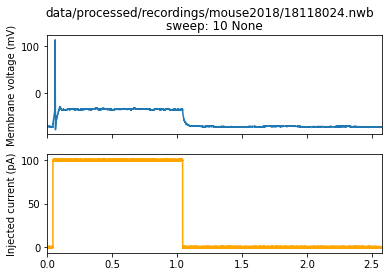

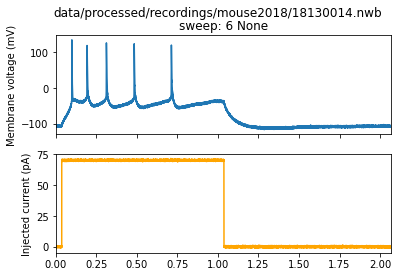

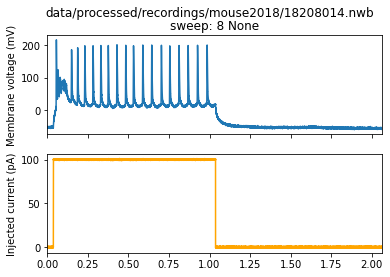

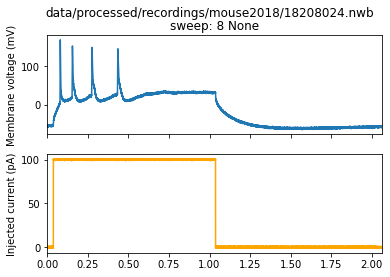

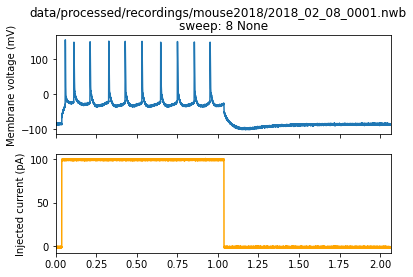

In [36]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    try:
        utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)
    except TypeError as e:
        print(e, row.path)

In [37]:
!dandi validate ./data/processed/recordings/mouse2018/

2021-11-10 13:35:39,478 [    INFO] NumExpr defaulting to 8 threads.
2021-11-10 13:35:42,577 [    INFO] ./data/processed/recordings/mouse2018/18118024.nwb: ok
2021-11-10 13:35:44,254 [    INFO] ./data/processed/recordings/mouse2018/18208014.nwb: ok
2021-11-10 13:35:45,921 [    INFO] ./data/processed/recordings/mouse2018/18208024.nwb: ok
2021-11-10 13:35:47,688 [    INFO] ./data/processed/recordings/mouse2018/2018_02_08_0001.nwb: ok
2021-11-10 13:35:49,325 [    INFO] ./data/processed/recordings/mouse2018/18130014.nwb: ok
Summary: No validation errors among 5 file(s)
2021-11-10 13:35:49,326 [    INFO] Logs saved in /Users/derek_howard/Library/Logs/dandi-cli/20211110183538Z-8341.log
